<a href="https://colab.research.google.com/github/Stepka/KMeans-for-1M-sales-dataset/blob/master/Looking_for_clusters_in_the_1M_dataset_via_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install ciso8601

  Stored in directory: /root/.cache/pip/wheels/72/cd/ca/9058cc007cf5b7110011a6879defcb5486e7b987e7dcf077c2
Successfully built ciso8601


In [0]:

import pandas as pd
import numpy as np
from collections import Counter
import time
import datetime
import ciso8601

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.cluster import KMeans, MiniBatchKMeans


In [0]:
from google.colab import drive
drive.mount('/drive')

default_path = "/drive/My Drive/Colab Notebooks/100K"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /drive


In [0]:
######################
###   load data    ###
######################

In [0]:
dataset_csv = pd.read_csv(default_path + "/1000000 Sales Records.csv")

In [0]:

print("Num rows: {}\n".format(len(dataset_csv.index)))

dataset_csv.head(10)

Num rows: 1000000



,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Sub-Saharan Africa,South Africa,Fruits,Offline,M,7/27/2012,443368995,7/28/2012,1593,9.33,6.92,14862.69,11023.56,3839.13
1,Middle East and North Africa,Morocco,Clothes,Online,M,9/14/2013,667593514,10/19/2013,4611,109.28,35.84,503890.08,165258.24,338631.84
2,Australia and Oceania,Papua New Guinea,Meat,Offline,M,5/15/2015,940995585,6/4/2015,360,421.89,364.69,151880.40,131288.40,20592.00
3,Sub-Saharan Africa,Djibouti,Clothes,Offline,H,5/17/2017,880811536,7/2/2017,562,109.28,35.84,61415.36,20142.08,41273.28
4,Europe,Slovakia,Beverages,Offline,L,10/26/2016,174590194,12/4/2016,3973,47.45,31.79,188518.85,126301.67,62217.18
5,Asia,Sri Lanka,Fruits,Online,L,11/7/2011,830192887,12/18/2011,1379,9.33,6.92,12866.07,9542.68,3323.39
6,Sub-Saharan Africa,Seychelles,Beverages,Online,M,1/18/2013,425793445,2/16/2013,597,47.45,31.79,28327.65,18978.63,9349.02
7,Sub-Saharan Africa,Tanzania,Beverages,Online,L,11/30/2016,659878194,1/16/2017,1476,47.45,31.79,70036.20,46922.04,23114.16
8,Sub-Saharan Africa,Ghana,Office Supplies,Online,L,3/23/2017,601245963,4/15/2017,896,651.21,524.96,583484.16,470364.16,113120.00
9,Sub-Saharan Africa,Tanzania,Cosmetics,Offline,L,5/23/2016,739008080,5/24/2016,7768,437.20,263.33,3396169.60,2045547.44,1350622.16


In [0]:
#########################
###  preprocess data  ###
#########################

In [0]:
# convert from %m/%d/%Y to YYYY-mm-dd
add_zero = lambda s: s if len(s) > 1 else "0" + s
reconvert = lambda d: d[2] + "-" + add_zero(d[0]) + "-" + add_zero(d[1])

dataset = dataset_csv.copy()

dataset['Order Date'] = dataset_csv['Order Date'].map(lambda s: int(time.mktime(ciso8601.parse_datetime(reconvert(s.split("/"))).timetuple()) / (60*60*24)))
dataset['Ship Date'] = dataset_csv['Ship Date'].map(lambda s: int(time.mktime(ciso8601.parse_datetime(reconvert(s.split("/"))).timetuple()) / (60*60*24)))

dataset.head()

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Sub-Saharan Africa,South Africa,Fruits,Offline,M,15548,443368995,15549,1593,9.33,6.92,14862.69,11023.56,3839.13
1,Middle East and North Africa,Morocco,Clothes,Online,M,15962,667593514,15997,4611,109.28,35.84,503890.08,165258.24,338631.84
2,Australia and Oceania,Papua New Guinea,Meat,Offline,M,16570,940995585,16590,360,421.89,364.69,151880.40,131288.40,20592.00
3,Sub-Saharan Africa,Djibouti,Clothes,Offline,H,17303,880811536,17349,562,109.28,35.84,61415.36,20142.08,41273.28
4,Europe,Slovakia,Beverages,Offline,L,17100,174590194,17139,3973,47.45,31.79,188518.85,126301.67,62217.18


In [0]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

Region            0
Country           0
Item Type         0
Sales Channel     0
Order Priority    0
Order Date        0
Order ID          0
Ship Date         0
Units Sold        0
Unit Price        0
Unit Cost         0
Total Revenue     0
Total Cost        0
Total Profit      0
dtype: int64

In [0]:
# Outlier detection 

def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

In [0]:
# detect outliers 
Outliers_to_drop = detect_outliers(dataset, 2, ["Total Revenue", "Units Sold", "Unit Price"])
dataset.loc[Outliers_to_drop] # Show the outliers rows

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit


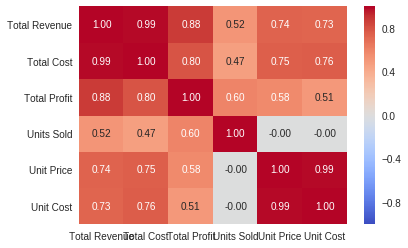

In [0]:
# Correlation matrix between numerical values 
g = sns.heatmap(dataset[["Total Revenue", "Total Cost", "Total Profit", "Units Sold", "Unit Price", "Unit Cost"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [0]:
countries = dataset.groupby(['Country']).agg(['count']).index.values

print(countries)

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda ' 'Armenia' 'Australia' 'Austria' 'Azerbaijan'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bhutan' 'Bosnia and Herzegovina' 'Botswana' 'Brunei' 'Bulgaria'
 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde'
 'Central African Republic' 'Chad' 'China' 'Comoros' 'Costa Rica'
 "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus' 'Czech Republic'
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'East Timor' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Ethiopia'
 'Federated States of Micronesia' 'Fiji' 'Finland' 'France' 'Gabon'
 'Georgia' 'Germany' 'Ghana' 'Greece' 'Greenland' 'Grenada' 'Guatemala'
 'Guinea' 'Guinea-Bissau' 'Haiti' 'Honduras' 'Hungary' 'Iceland' 'India'
 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan'
 'Jordan' 'Kazakhstan' 'Kenya' 'Kiribati' 'Kosovo' 'Kuwait' 'Kyrgyzstan'
 'Laos' 

In [0]:
regions = dataset.groupby(['Region']).agg(['count']).index.values

print(regions)

['Asia' 'Australia and Oceania' 'Central America and the Caribbean'
 'Europe' 'Middle East and North Africa' 'North America'
 'Sub-Saharan Africa']


In [0]:
item_types = dataset.groupby(['Item Type']).agg(['count']).index.values

print(item_types)

['Baby Food' 'Beverages' 'Cereal' 'Clothes' 'Cosmetics' 'Fruits'
 'Household' 'Meat' 'Office Supplies' 'Personal Care' 'Snacks'
 'Vegetables']


In [0]:
sale_channels = dataset.groupby(['Sales Channel']).agg(['count']).index.values

print(sale_channels)

['Offline' 'Online']


In [0]:
order_priorities = dataset.groupby(['Order Priority']).agg(['count']).index.values

print(order_priorities)

['C' 'H' 'L' 'M']


In [0]:

dataset = pd.get_dummies(dataset, columns = ["Region", 'Item Type', 'Sales Channel', 'Order Priority'])

dataset.head()

,Country,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit,...,Item Type_Office Supplies,Item Type_Personal Care,Item Type_Snacks,Item Type_Vegetables,Sales Channel_Offline,Sales Channel_Online,Order Priority_C,Order Priority_H,Order Priority_L,Order Priority_M
0,South Africa,15548,443368995,15549,1593,9.33,6.92,14862.69,11023.56,3839.13,...,0,0,0,0,1,0,0,0,0,1
1,Morocco,15962,667593514,15997,4611,109.28,35.84,503890.08,165258.24,338631.84,...,0,0,0,0,0,1,0,0,0,1
2,Papua New Guinea,16570,940995585,16590,360,421.89,364.69,151880.40,131288.40,20592.00,...,0,0,0,0,1,0,0,0,0,1
3,Djibouti,17303,880811536,17349,562,109.28,35.84,61415.36,20142.08,41273.28,...,0,0,0,0,1,0,0,1,0,0
4,Slovakia,17100,174590194,17139,3973,47.45,31.79,188518.85,126301.67,62217.18,...,0,0,0,0,1,0,0,0,1,0


In [0]:
dataset['Country'] = dataset_csv['Country'].map(lambda c: np.where(countries == c)[0][0])

dataset.head()

,Country,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit,...,Item Type_Office Supplies,Item Type_Personal Care,Item Type_Snacks,Item Type_Vegetables,Sales Channel_Offline,Sales Channel_Online,Order Priority_C,Order Priority_H,Order Priority_L,Order Priority_M
0,150,15548,443368995,15549,1593,9.33,6.92,14862.69,11023.56,3839.13,...,0,0,0,0,1,0,0,0,0,1
1,108,15962,667593514,15997,4611,109.28,35.84,503890.08,165258.24,338631.84,...,0,0,0,0,0,1,0,0,0,1
2,125,16570,940995585,16590,360,421.89,364.69,151880.40,131288.40,20592.00,...,0,0,0,0,1,0,0,0,0,1
3,40,17303,880811536,17349,562,109.28,35.84,61415.36,20142.08,41273.28,...,0,0,0,0,1,0,0,1,0,0
4,146,17100,174590194,17139,3973,47.45,31.79,188518.85,126301.67,62217.18,...,0,0,0,0,1,0,0,0,1,0


In [0]:
##########################
### feature enginering ###
##########################

In [0]:

dataset["Unit Revenue"] = dataset["Unit Price"] - dataset["Unit Cost"]
dataset["Ship Time"] = dataset["Ship Date"] - dataset["Order Date"]

dataset.head()

,Country,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit,...,Item Type_Snacks,Item Type_Vegetables,Sales Channel_Offline,Sales Channel_Online,Order Priority_C,Order Priority_H,Order Priority_L,Order Priority_M,Unit Revenue,Ship Time
0,150,15548,443368995,15549,1593,9.33,6.92,14862.69,11023.56,3839.13,...,0,0,1,0,0,0,0,1,2.41,1
1,108,15962,667593514,15997,4611,109.28,35.84,503890.08,165258.24,338631.84,...,0,0,0,1,0,0,0,1,73.44,35
2,125,16570,940995585,16590,360,421.89,364.69,151880.40,131288.40,20592.00,...,0,0,1,0,0,0,0,1,57.20,20
3,40,17303,880811536,17349,562,109.28,35.84,61415.36,20142.08,41273.28,...,0,0,1,0,0,1,0,0,73.44,46
4,146,17100,174590194,17139,3973,47.45,31.79,188518.85,126301.67,62217.18,...,0,0,1,0,0,0,1,0,15.66,39


In [0]:
train_data = dataset
train_ids = dataset["Order ID"]

train_data = train_data.drop(labels = ["Order ID"], axis = 1)

train_data.head()

,Country,Order Date,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit,Region_Asia,...,Item Type_Snacks,Item Type_Vegetables,Sales Channel_Offline,Sales Channel_Online,Order Priority_C,Order Priority_H,Order Priority_L,Order Priority_M,Unit Revenue,Ship Time
0,150,15548,15549,1593,9.33,6.92,14862.69,11023.56,3839.13,0,...,0,0,1,0,0,0,0,1,2.41,1
1,108,15962,15997,4611,109.28,35.84,503890.08,165258.24,338631.84,0,...,0,0,0,1,0,0,0,1,73.44,35
2,125,16570,16590,360,421.89,364.69,151880.40,131288.40,20592.00,0,...,0,0,1,0,0,0,0,1,57.20,20
3,40,17303,17349,562,109.28,35.84,61415.36,20142.08,41273.28,0,...,0,0,1,0,0,1,0,0,73.44,46
4,146,17100,17139,3973,47.45,31.79,188518.85,126301.67,62217.18,0,...,0,0,1,0,0,0,1,0,15.66,39


In [0]:
train_data.dtypes

Country                                       int64
Order Date                                    int64
Ship Date                                     int64
Units Sold                                    int64
Unit Price                                  float64
Unit Cost                                   float64
Total Revenue                               float64
Total Cost                                  float64
Total Profit                                float64
Region_Asia                                   uint8
Region_Australia and Oceania                  uint8
Region_Central America and the Caribbean      uint8
Region_Europe                                 uint8
Region_Middle East and North Africa           uint8
Region_North America                          uint8
Region_Sub-Saharan Africa                     uint8
Item Type_Baby Food                           uint8
Item Type_Beverages                           uint8
Item Type_Cereal                              uint8
Item Type_Cl

In [0]:
########################
### figure out model ###
########################

In [0]:
# Parameters
num_steps = 150 # Total steps 
k = 25 # The number of clusters


kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=num_steps, verbose=1)


In [0]:

clusters = kmeans.fit_predict(train_data)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 2.7698343284051304e+16
start iteration
done sorting
end inner loop
Iteration 1, inertia 2.603447404617465e+16
start iteration
done sorting
end inner loop
Iteration 2, inertia 2.559498305409723e+16
start iteration
done sorting
end inner loop
Iteration 3, inertia 2.5369170687763076e+16
start iteration
done sorting
end inner loop
Iteration 4, inertia 2.5228778058296144e+16
start iteration
done sorting
end inner loop
Iteration 5, inertia 2.512980641988646e+16
start iteration
done sorting
end inner loop
Iteration 6, inertia 2.505456217778391e+16
start iteration
done sorting
end inner loop
Iteration 7, inertia 2.499813640336492e+16
start iteration
done sorting
end inner loop
Iteration 8, inertia 2.4949783412242696e+16
start iteration
done sorting
end inner loop
Iteration 9, inertia 2.4900709249096444e+16
start iteration
done sorting
end inner loop
Iteration 10, inertia 2.4843203351535188e+16
start iterat

In [0]:
centroids = kmeans.cluster_centers_
print(centroids)

[[ 9.14545150e+01  1.59903104e+04  1.60153327e+04  5.02797300e+03
   5.57750245e+02  4.49808703e+02  2.68107282e+06  2.18449978e+06
   4.96573036e+05  1.46605382e-01  7.67020971e-02  1.10456765e-01
   2.60174279e-01  1.22857416e-01  2.26467490e-02  2.60557311e-01
  -3.85247390e-14  7.09154957e-15  4.12447854e-14  1.63202785e-14
  -1.53349555e-14  6.88338275e-15  2.86316193e-01  4.28851862e-01
   2.84831945e-01  2.24958940e-14 -2.66453526e-14 -4.24105195e-14
   5.02633343e-01  4.97366657e-01  2.53758499e-01  2.49257876e-01
   2.52034856e-01  2.44948770e-01  1.07941542e+02  2.50222637e+01
   1.42803792e+01]
 [ 9.18187461e+01  1.59903729e+04  1.60153925e+04  4.82356022e+03
   2.17040908e+02  1.48273769e+02  7.00606572e+05  4.61176363e+05
   2.39430209e+05  1.45620375e-01  8.19250846e-02  1.07979120e-01
   2.59496357e-01  1.25256697e-01  2.13503126e-02  2.58372053e-01
   9.46366087e-02  4.52415883e-14  1.15310044e-01  5.52474733e-14
   5.59284116e-02  8.04772915e-14  3.62416107e-02  5.8612

In [0]:
train_data['Cluster'] = clusters

train_data.head(20)

,Country,Order Date,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit,Region_Asia,...,Item Type_Vegetables,Sales Channel_Offline,Sales Channel_Online,Order Priority_C,Order Priority_H,Order Priority_L,Order Priority_M,Unit Revenue,Ship Time,Cluster
0,150,15548,15549,1593,9.33,6.92,14862.69,11023.56,3839.13,0,...,0,1,0,0,0,0,1,2.41,1,21
1,108,15962,15997,4611,109.28,35.84,503890.08,165258.24,338631.84,0,...,0,0,1,0,0,0,1,73.44,35,14
2,125,16570,16590,360,421.89,364.69,151880.40,131288.40,20592.00,0,...,0,1,0,0,0,0,1,57.20,20,0
3,40,17303,17349,562,109.28,35.84,61415.36,20142.08,41273.28,0,...,0,1,0,0,1,0,0,73.44,46,21
4,146,17100,17139,3973,47.45,31.79,188518.85,126301.67,62217.18,0,...,0,1,0,0,0,1,0,15.66,39,0
5,154,15285,15326,1379,9.33,6.92,12866.07,9542.68,3323.39,1,...,0,0,1,0,0,1,0,2.41,41,21
6,143,15723,15752,597,47.45,31.79,28327.65,18978.63,9349.02,0,...,0,0,1,0,0,0,1,15.66,29,21
7,162,17135,17182,1476,47.45,31.79,70036.20,46922.04,23114.16,0,...,0,0,1,0,0,1,0,15.66,47,21
8,57,17248,17271,896,651.21,524.96,583484.16,470364.16,113120.00,0,...,0,0,1,0,0,1,0,126.25,23,22
9,162,16944,16945,7768,437.20,263.33,3396169.60,2045547.44,1350622.16,0,...,0,1,0,0,0,1,0,173.87,1,23


In [0]:
train_data.groupby(['Cluster'])[['Ship Time', 'Unit Revenue']].describe()

Ship Time                                                     \
            count       mean        std  min   25%   50%   75%   max   
Cluster                                                                
0        112249.0  25.030851  14.713435  0.0  12.0  25.0  38.0  50.0   
1         10620.0  24.997175  14.819973  0.0  12.0  25.0  38.0  50.0   
2         23422.0  25.033131  14.748016  0.0  12.0  25.0  38.0  50.0   
3         15485.0  25.116823  14.664159  0.0  13.0  25.0  38.0  50.0   
4         58336.0  25.046386  14.741407  0.0  12.0  25.0  38.0  50.0   
5         20522.0  24.997807  14.733477  0.0  12.0  25.0  38.0  50.0   
6         13983.0  25.006794  14.732076  0.0  12.0  25.0  38.0  50.0   
7         19722.0  24.956090  14.760718  0.0  12.0  25.0  38.0  50.0   
8         32208.0  25.011302  14.681658  0.0  12.0  25.0  38.0  50.0   
9         38354.0  24.970303  14.736730  0.0  12.0  25.0  38.0  50.0   
10        15728.0  25.073372  14.630459  0.0  13.0  25.0  38.0  50.0   
11        12188.0  24.870118  14.755471  0.0  12.0  25.0  38.0  50.0   
12        68463.0  24.974585  14.713044  0.0  12.0  25.0  38.0  50.0   
13        22656.0  25.171081  14.705125  0.0  12.0  25.0  38.0  50.0   
14       114028.0  25.044226  14.712777  0.0  12.0  25.0  38.0  50.0   
15        21571.0  25.058458  14.767729  0.0  12.0  25.0  38.0  50.0   
16        26730.0  25.023120  14.724730  0.0  12.0  25.0  38.0  50.0   
17        13565.0  24.916034  14.686625  0.0  12.0  25.0  38.0  50.0   
18        52725.0  24.844704  14.720838  0.0  12.0  25.0  38.0  50.0   
19        10428.0  25.135884  14.682877  0.0  13.0  25.0  38.0  50.0   
20        13891.0  25.010222  14.661264  0.0  12.0  25.0  38.0  50.0   
21       176663.0  25.022557  14.721433  0.0  12.0  25.0  38.0  50.0   
22        80942.0  25.037323  14.719987  0.0  12.0  25.0  38.0  50.0   
23        10544.0  25.020106  14.732055  0.0  12.0  25.0  38.0  50.0   
24        14977.0  25.024504  14.681842  0.0  12.0  25.0  38.0  50.0   

        Unit Revenue                                                    \
               count        mean           std     min     25%     50%   
Cluster                                                                  
0           112249.0   53.826297  4.020731e+01   15.66   15.66   55.14   
1            10620.0  173.870000  4.584638e-11  173.87  173.87  173.87   
2            23422.0  103.384026  4.604254e+01   57.20   57.20  126.25   
3            15485.0  145.789859  1.973962e+01  126.25  126.25  126.25   
4            58336.0   82.483591  4.063496e+01   25.06   55.14   63.13   
5            20522.0  113.480869  4.614928e+01   57.20   57.20  126.25   
6            13983.0  148.250154  1.961088e+01  126.25  126.25  165.73   
7            19722.0  131.807413  3.888596e+01   95.86   95.86   95.86   
8            32208.0  107.311887  3.364021e+01   63.13   88.59   95.86   
9            38354.0   73.440000  4.507742e-11   73.44   73.44   73.44   
10           15728.0  146.765643  1.972538e+01  126.25  126.25  165.73   
11           12188.0  154.697109  1.771665e+01  126.25  126.25  165.73   
12           68463.0   87.066394  3.812587e+01   55.14   57.20   63.13   
13           22656.0  107.727887  4.644099e+01   57.20   57.20  126.25   
14          114028.0   58.320732  4.002638e+01   15.66   25.06   57.20   
15           21571.0  106.984630  4.639420e+01   57.20   57.20  126.25   
16           26730.0  114.899449  3.597690e+01   88.59   88.59   95.86   
17           13565.0   76.639878  3.105617e+01   57.20   57.20   57.20   
18           52725.0   85.547385  3.607978e+01   55.14   63.13   63.13   
19           10428.0  173.870000  4.465265e-11  173.87  173.87  173.87   
20           13891.0   77.312037  3.137376e+01   57.20   57.20   57.20   
21          176663.0   29.522617  3.886806e+01    2.41    2.41   15.66   
22           80942.0   68.562259  4.222736e+01   25.06   25.06   57.20   
23           10544.0  173.870000  4.539162e-11  173.87  173.87  173

In [0]:
########################
### cross validation ###
########################